https://otexts.com/fpp3/

# Note: I am just focusing on testing models to forecast SPY for now, will try other ETFs in the future

## Import Libraries

In [588]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
from sklearn.metrics import root_mean_squared_error
from pmdarima.arima import auto_arima
from helper import perform_adf_test, transform_data, split_data, undo_transformations, evaluate_model, random_walk, evaluate_rw

sns.set_theme()

## Data Collection

In [589]:
# Get tickers we are interested in
tickers = ['SPY', 'VOO', 'NASDX', 'QQQ', 'DIA'] # common etfs (https://www.bankrate.com/investing/best-index-funds/#NASDX)
#test_tickers = ['BTC-USD']
NUM_TICKERS = len(tickers)

# Set start and end dates that specify the amount of data we will pull
START_DATE = datetime.today() + relativedelta(months=-4)
END_DATE = datetime.today()

# Pull data using API
data = yf.download(tickers, start=START_DATE, end=END_DATE)['Adj Close']

spy_data = yf.download('SPY', start = START_DATE, end =END_DATE)['Adj Close']

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  1 of 1 completed


## EDA

In [590]:
# Checking for null values
data.isna().sum()

Ticker
DIA      0
NASDX    0
QQQ      0
SPY      0
VOO      0
dtype: int64

In [591]:
# Get data into long format so we can visualize it
long_data = pd.melt(data.reset_index(), id_vars = ['Date'], value_vars = tickers)

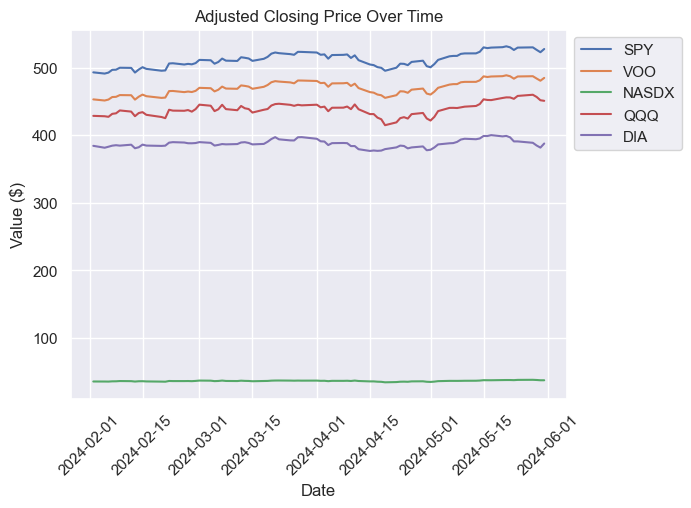

In [592]:
# Time Series Plots
sns.lineplot(data = long_data, x = 'Date', y = 'value', hue = 'Ticker');
plt.title('Adjusted Closing Price Over Time');
plt.xticks(rotation = 45);
plt.ylabel('Value ($)');
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1));
    

EDA on SPY

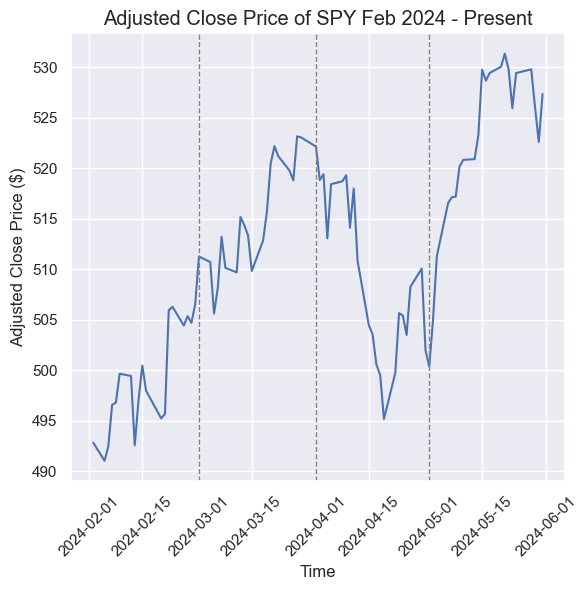

In [593]:
fig, ax = plt.subplots(figsize=(6,6))

plt.style.use('ggplot')
plt.plot(spy_data);
plt.xticks(rotation = 45);
plt.title('Adjusted Close Price of SPY Feb 2024 - Present');
plt.ylabel('Adjusted Close Price ($)');
plt.xlabel('Time');
for date in pd.date_range(start=spy_data.index.min(), end=spy_data.index.max(), freq='MS'):
    plt.axvline(x=date, color='grey', linestyle='--', linewidth=1)
plt.tight_layout()

plt.savefig('spy_time_series_month.png', dpi = 300)

In [594]:
full_spy_data = yf.download('SPY', start = datetime.today()-timedelta(3650), end =datetime.today())['Adj Close']

[*********************100%%**********************]  1 of 1 completed


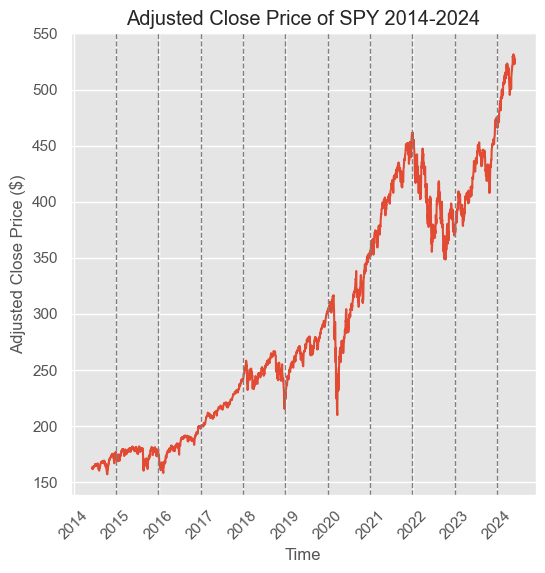

In [595]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(6,6))
plt.plot(full_spy_data);
plt.xticks(rotation = 45);
plt.title('Adjusted Close Price of SPY 2014-2024');
plt.ylabel('Adjusted Close Price ($)');
plt.xlabel('Time');
for date in pd.date_range(start=full_spy_data.index.min(), end=full_spy_data.index.max(), freq='YE'):
    plt.axvline(x=date, color='grey', linestyle='--', linewidth=1)

plt.savefig('spy_time_series_year.png', dpi = 300)

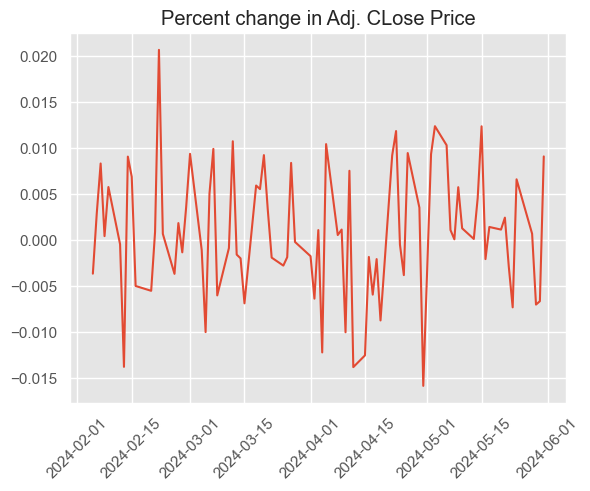

In [596]:
plt.plot(spy_data.pct_change());
plt.xticks(rotation = 45);
plt.title('Percent change in Adj. CLose Price');

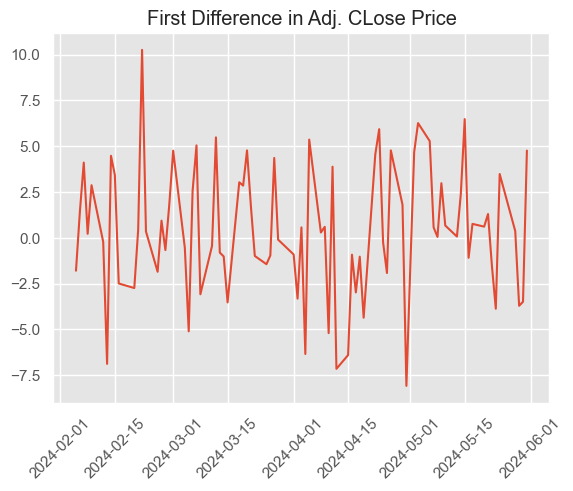

In [597]:
plt.plot(spy_data.diff());
plt.xticks(rotation = 45);
plt.title('First Difference in Adj. CLose Price');

Here we notice that the 1st difference of the stock price for spy is stationary.

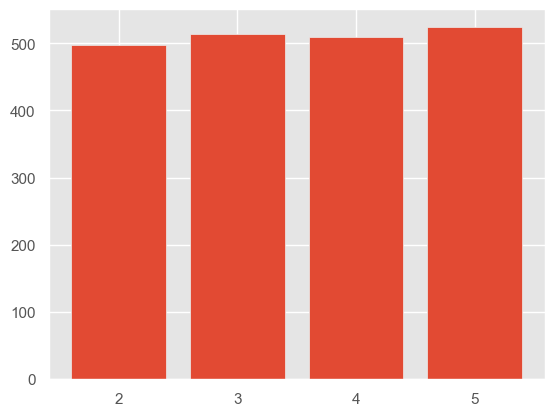

In [598]:
price_by_month = spy_data.groupby(spy_data.index.month).median() 
plt.xticks(range(1, 13))
plt.bar(price_by_month.index, price_by_month);

How does this compare to Bitcoin and Coinbase?

In [599]:
crypto_equities_tickers = ['SPY', 'VOO', 'NASDX', 'QQQ', 'DIA', 'BTC', 'COIN'] 

crypto_equities = yf.download(crypto_equities_tickers, start=START_DATE, end=END_DATE)['Adj Close']

[*********************100%%**********************]  7 of 7 completed


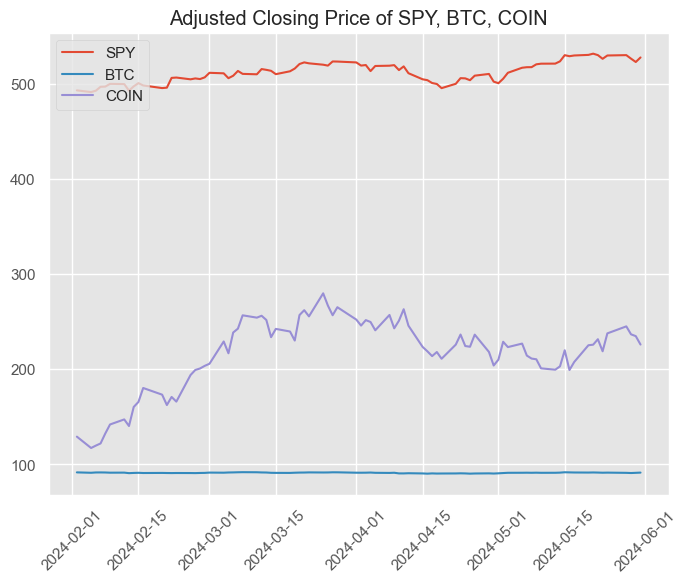

In [600]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(crypto_equities['SPY']);
ax.plot(crypto_equities['BTC']);
ax.plot(crypto_equities['COIN']);
plt.title('Adjusted Closing Price of SPY, BTC, COIN');
#plt.xlim(data.index.min(), date.today());
plt.xticks(rotation = 45);
ax.legend(labels = ['SPY', 'BTC', 'COIN'], loc = 'upper left');

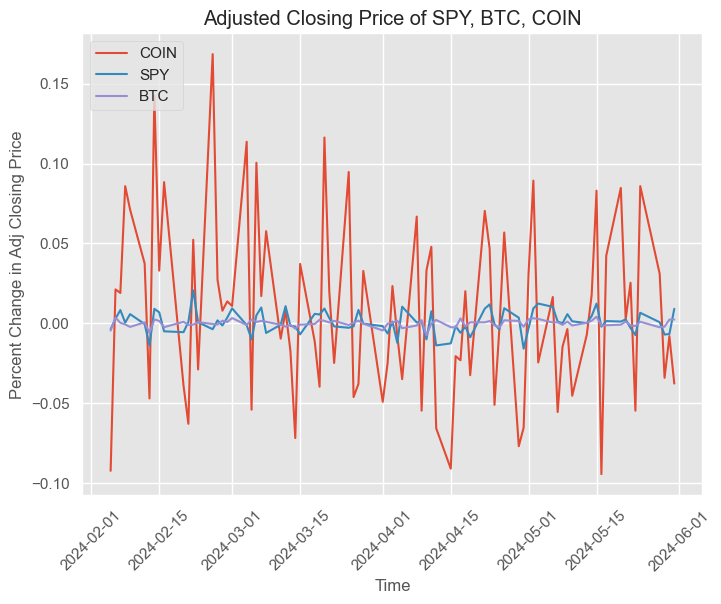

In [601]:
# Returns
returns = crypto_equities.pct_change().dropna()

fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(returns['COIN']);
ax.plot(returns['SPY']);
ax.plot(returns['BTC']);
plt.title('Adjusted Closing Price of SPY, BTC, COIN');
#plt.xlim(datetime(2020, 10, 1), date.today());
plt.xticks(rotation = 45);
plt.ylabel('Percent Change in Adj Closing Price');
plt.xlabel('Time')
ax.legend(labels = ['COIN', 'SPY', 'BTC'], loc = 'upper left');

Other vizs to try: lagplots

Autocorrelation is the correlation between lagged values of a time series. e.g. You can measure the autocorrelation of the price of Bitcoin today and the price 2 days ago.

Important Note: Autocorrelation takes into the account both the indirect and direct effects that the price 2 days ago had on today's price. An example of an indirect effect is the price 2 days ago affected the price 1 day ago which affected the price today.

If we wanted to only measure direct effect we can use the PACF (Partial Autocorrelation Function).

for more info(https://www.youtube.com/watch?v=DeORzP0go5I&t=465s)

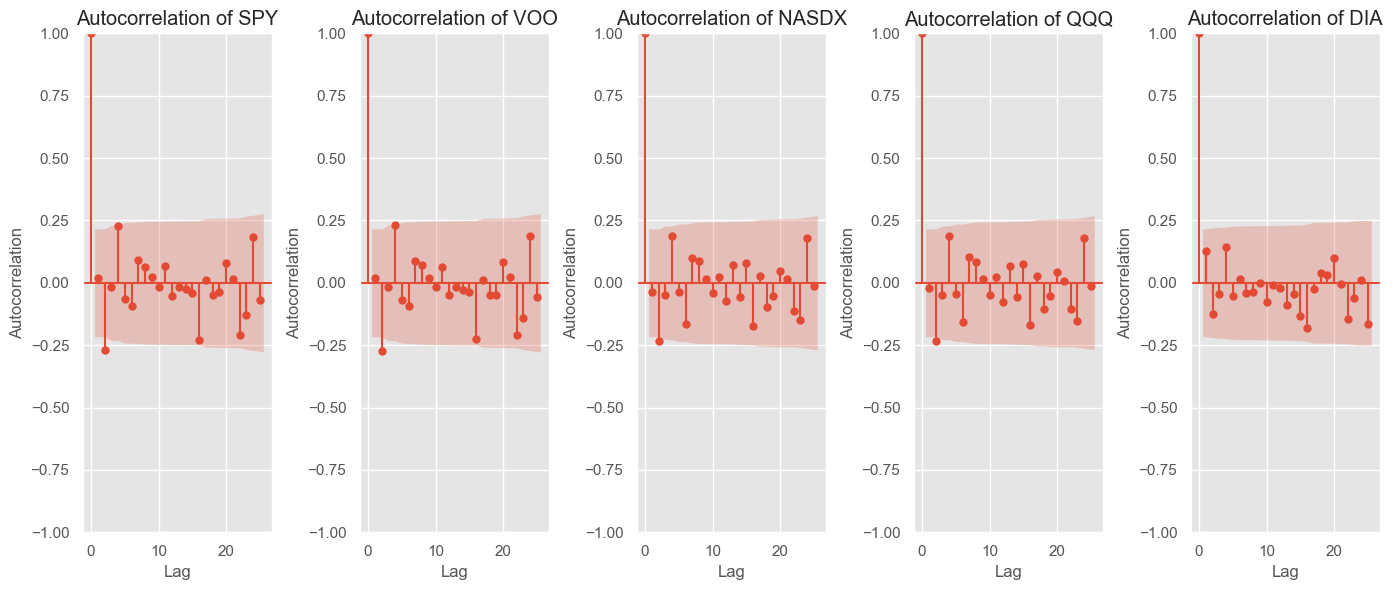

In [602]:
# ACF plots
fig, ax = plt.subplots(1, NUM_TICKERS, figsize=(14, 6))

# first difference makes the data have stationarity so we can create the ACF and PACF plots, which is why we plot the first difference

for i, ticker in enumerate(tickers):
  plot_acf(data[ticker].diff(periods=1).dropna(), ax = ax[i], lags = 25) #.diff() calculates the first difference
  ax[i].set(title = f'Autocorrelation of {ticker}', xlabel = 'Lag', ylabel = 'Autocorrelation')

plt.tight_layout()
plt.show()

The ACF plot tells us how correlated today's price is with the kth previous day's price. We are looking for points outside the blue band. Disregard x = 0 because that is the correlation of today's price with itself.

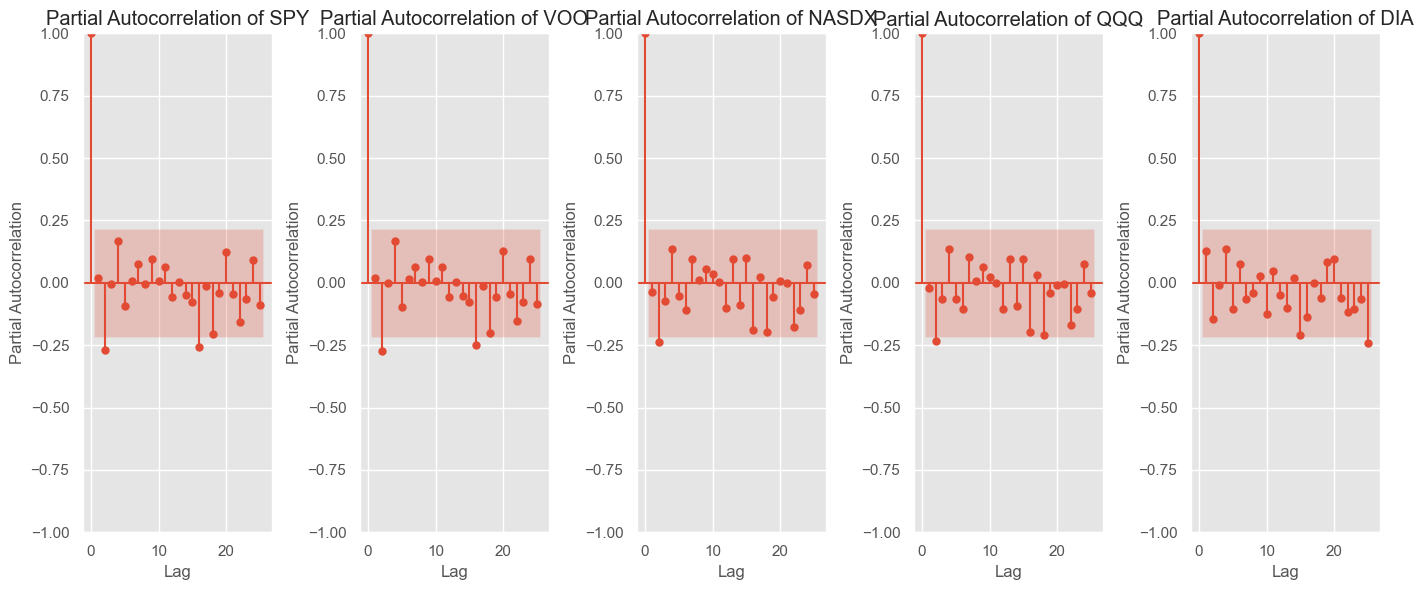

In [603]:
# PACF plots
fig, ax = plt.subplots(1, NUM_TICKERS, figsize= (14, 6))

for i, ticker in enumerate(tickers):
  plot_pacf(data[ticker].diff(periods=1).dropna(), ax = ax[i], lags = 25)
  ax[i].set(title = f'Partial Autocorrelation of {ticker}', xlabel = 'Lag', ylabel = 'Partial Autocorrelation')

plt.tight_layout()
plt.show()

## ACF and PACF plots for SPY

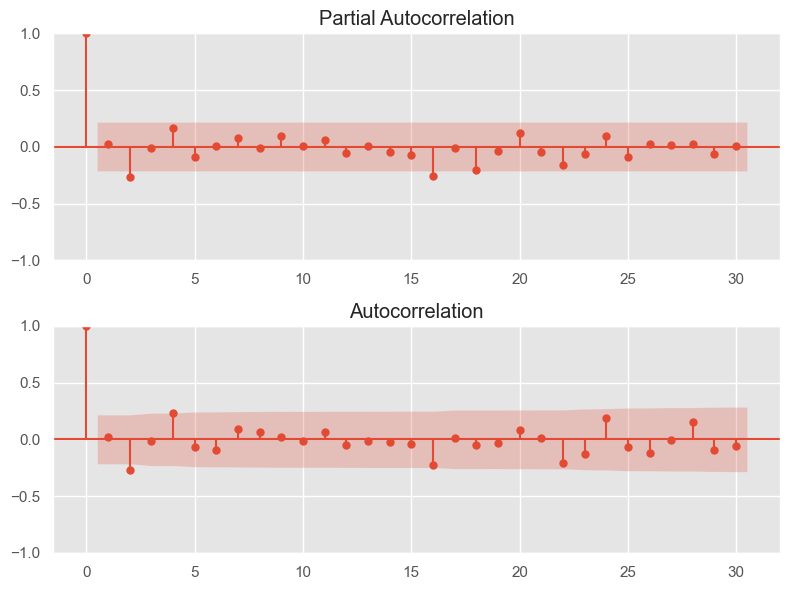

In [604]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))
plot_pacf(spy_data.diff().dropna(), lags = 30, ax = ax[0])
fig = plot_acf(spy_data.diff().dropna(), lags = 30, ax = ax[1])
plt.tight_layout()
plt.savefig('pacf_acf.png', dpi = 300)

In both the ACF and PACF plots, we notice that there are not many lags that have partial autocorrelation or autocorrelation significantly greater than 0.

Stationary Tests (Dicky-Fuller)

In [605]:
# Conduct ADF Test on all tickers
for ticker in tickers:
  print(f"ADF Test for {ticker}")
  perform_adf_test(data[ticker].values)
  print()

ADF Test for SPY
ADF Statistic: -1.604008
p-value: 0.481580

ADF Test for VOO
ADF Statistic: -1.605818
p-value: 0.480670

ADF Test for NASDX
ADF Statistic: -1.991821
p-value: 0.290171

ADF Test for QQQ
ADF Statistic: -1.963524
p-value: 0.302792

ADF Test for DIA
ADF Statistic: -2.557212
p-value: 0.102167



All time series were not stationary, which is needed for the models we will use. To fix this, we use first difference

# Modelling

## Data Preparation

In [606]:
transformed_data = data.copy()
transformed_data = transform_data(transformed_data)

In [607]:
# Conduct ADF Test on all tickers
for ticker in tickers:
  print(f"ADF Test for {ticker}")
  perform_adf_test(transformed_data[ticker].values)
  print()

ADF Test for SPY
ADF Statistic: -8.103378
p-value: 0.000000

ADF Test for VOO
ADF Statistic: -8.143198
p-value: 0.000000

ADF Test for NASDX
ADF Statistic: -8.039994
p-value: 0.000000

ADF Test for QQQ
ADF Statistic: -7.953320
p-value: 0.000000

ADF Test for DIA
ADF Statistic: -7.529105
p-value: 0.000000



In [608]:
TRAIN_END = datetime(2024, 3, 31)  # date to train the model until
TEST_END = datetime.today() # date to start forecasting after

In [609]:
spy_train, spy_test = split_data(transformed_data, 'SPY', TRAIN_END, TEST_END)
og_spy_train, og_spy_test = split_data(data, 'SPY', TRAIN_END, TEST_END)

Testing undo_transformations() function

In [610]:
test_transformed_values = undo_transformations(spy_train, pd.Series(og_spy_train.iloc[0]))

In [611]:
assert (og_spy_train[1:].values == test_transformed_values).all()

## Model Fitting & Evaluation

## Model 1: ARIMA 

In [612]:
# Trying auto arima
autoarima = auto_arima(y = og_spy_train, start_p = 1, d = 0, start_q = 1, max_p = 14, max_q = 14, max_d = 2, seasonal=False)
autoarima

ARIMA(order=(1, 0, 2), scoring_args={}, suppress_warnings=True)

The auto arima function tells us that an ARIMA(1,0,0) model is the best fit. This is equivalent to an AR 1 model.

This is surprising as the from the EDA, we saw that the data was clearly not stationary, so it is interesting that the differncing component of the ARIMA model is 0.

In [613]:
# ARIMA model without doing the differencing manually
model = ARIMA(og_spy_train, order = (1, 0, 0))
model_fit = model.fit()

In [614]:
forecast = model_fit.get_prediction(start = og_spy_test.index[0], end = og_spy_test.index[-1])
predictions = forecast.predicted_mean
conf_ints = forecast.conf_int()
conf_ints.columns = ['lower', 'upper']

In [615]:
if type(og_spy_test.index) != type(predictions.index):
    og_spy_test.index = og_spy_test.index.to_timestamp()
df = pd.concat([og_spy_test, predictions], join = 'inner', axis = 1)
df.columns = ['actual', 'predicted']

print(f"RMSE of AUTOARIMA: {root_mean_squared_error(df['actual'], df['predicted'])}")

RMSE of AUTOARIMA: 12.543090136758218


In [616]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    SPY   No. Observations:                   39
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -104.016
Date:                Sat, 01 Jun 2024   AIC                            214.033
Time:                        21:57:04   BIC                            219.023
Sample:                    02-02-2024   HQIC                           215.823
                         - 03-28-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        507.5958      9.097     55.796      0.000     489.765     525.426
ar.L1          0.9590      0.068     14.204      0.000       0.827       1.091
sigma2        11.3779      2.437      4.669      0.0

The 1st lag component of the AR model is significant.

In [617]:
# Variables created for plotting
og_spy_train_timestamp = og_spy_train.copy()
og_spy_train_timestamp.index = og_spy_train_timestamp.index.to_timestamp()

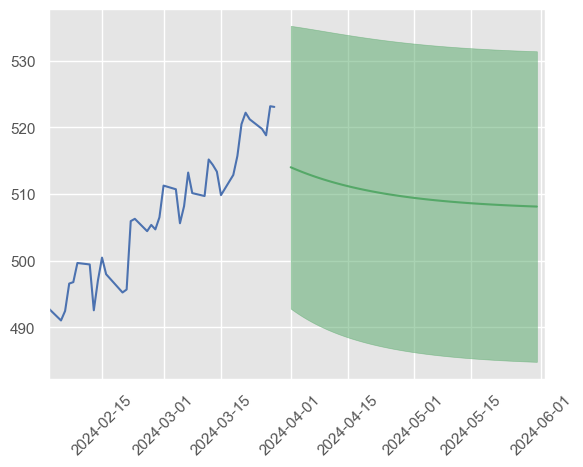

In [618]:
# Visualizing forecast
fig, ax = plt.subplots()

ax.plot(og_spy_train_timestamp, color = 'b')
plt.xlim(og_spy_train_timestamp.index[0], TEST_END);
ax.plot(predictions, color = 'g')
plt.fill_between(conf_ints.index, conf_ints.lower, conf_ints.upper, color='g', alpha=0.5)
plt.xticks(rotation = 45);

In [619]:
# standardizing indices and computing residuals
predictions.index = predictions.index.to_timestamp().normalize()
og_spy_test_timestamp = og_spy_test.copy()
og_spy_test_timestamp.index = og_spy_test_timestamp.index.to_timestamp()

df = pd.concat([og_spy_test_timestamp, predictions], join = 'inner', axis = 1)
df.columns = ['actual', 'predicted']

residuals = df['actual'] - df['predicted']

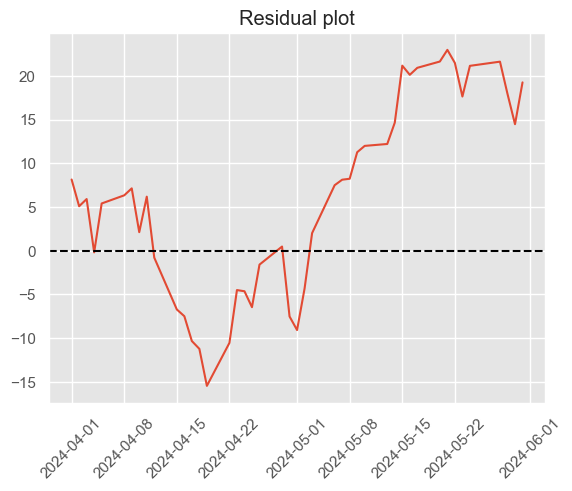

In [620]:
# plot residuals
plt.plot(residuals);
plt.xticks(rotation = 45);
plt.title('Residual plot');
plt.axhline(0, linestyle='--', color = 'black');

The residuals don't seem like random noise, so there is some pattern in the data that our model is failing to capture.

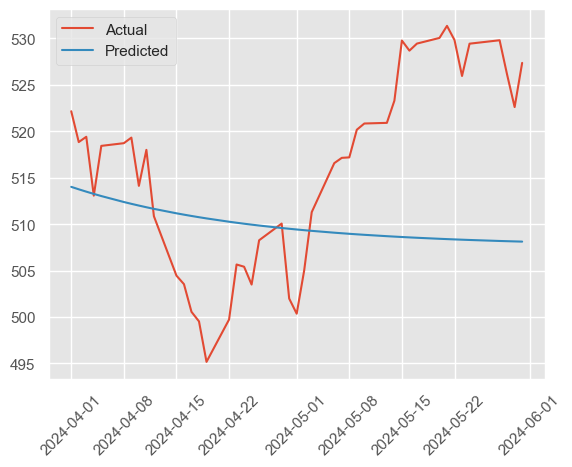

In [621]:
# Actual vs Predicted Plot
plt.plot(df['actual']);
plt.plot(df['predicted']);
plt.legend(labels = ['Actual', 'Predicted']);
plt.xticks(rotation = 45);

## Rolling Forecast Origin
### Credit: https://github.com/ritvikmath/Time-Series-Analysis/blob/master/SARIMA%20Model.ipynb
### Idea: Lets say we want to forecast k days into the future
1. Train on days 1, 2, ..., k-3 -> predict day k-2
2. Train on days 1, 2, ..., k-3, k-2 -> predict day k-1
3. Train on days 1, 2, ..., k-3, k-2, k-1 -> predict day k

Then we average all predictions

In [622]:
# Specify Order of ARIMA Model
BEST_ORDER = (1,1,0)

In [623]:
# Rolling forecast origin
rolling_predictions = pd.Series()
final_model_fit = None
for end_date in og_spy_test.index:
    train_data = spy_data[:end_date.to_timestamp()-timedelta(days=1)]
    train_data.index = pd.DatetimeIndex(train_data.index).to_period('D')
    model = ARIMA(train_data, order = BEST_ORDER)
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    rolling_predictions.loc[end_date] = pred.loc[end_date]
    # Save final model
    final_model_fit = model_fit

In [624]:
print(final_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                   82
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -218.309
Date:                Sat, 01 Jun 2024   AIC                            440.618
Time:                        21:57:06   BIC                            445.407
Sample:                    02-02-2024   HQIC                           442.539
                         - 05-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0504      0.120      0.419      0.676      -0.185       0.286
sigma2        12.8383      2.086      6.154      0.000       8.749      16.927
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [625]:
# Get results into a dataframe
df = pd.concat([og_spy_test, rolling_predictions], join = 'inner', axis = 1)
df.columns = ['actual', 'predicted']
df.index = df.index.to_timestamp()

#print results RMSE
print(f"RMSE of ARIMA (rolling predictions): {root_mean_squared_error(df['actual'], df['predicted'])}")

RMSE of ARIMA (rolling predictions): 3.8117637272901534


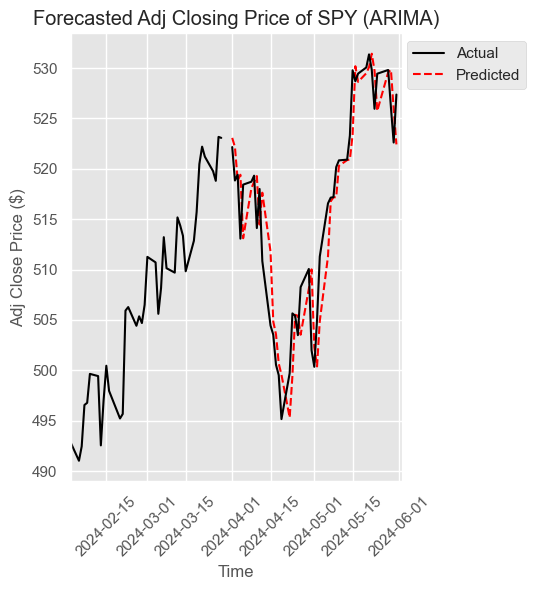

In [626]:
# Visualizing forecast
fig, ax = plt.subplots(figsize = (6, 6))

ax.plot(og_spy_train_timestamp, color = 'black')
plt.xlim(og_spy_train_timestamp.index[0], TEST_END);
ax.plot(df['predicted'], color = 'red', linestyle = '--')
ax.plot(df['actual'], color = 'black')
plt.xticks(rotation = 45);
plt.xlabel('Time');
plt.ylabel('Adj Close Price ($)');
plt.title('Forecasted Adj Closing Price of SPY (ARIMA)');
plt.legend(labels = ['Actual', 'Predicted'], loc = 'upper right', bbox_to_anchor=(1.4, 1));
plt.tight_layout()

plt.savefig('arima_plot.png', dpi = 300)

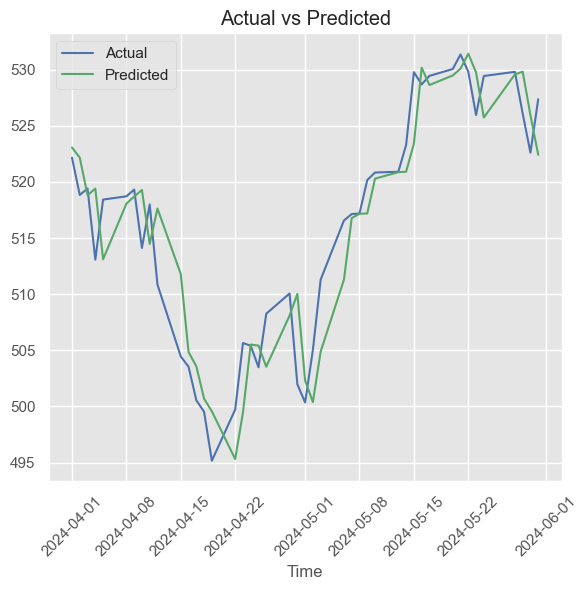

In [627]:
# Actual vs Predicted
fig, ax = plt.subplots(figsize = (6, 6))

plt.plot(df['actual'], color = 'b');
plt.plot(df['predicted'], color = 'g');
plt.legend(labels = ['Actual', 'Predicted']);
plt.xticks(rotation = 45);
plt.xlabel('Time');
plt.title('Actual vs Predicted');

plt.tight_layout()


plt.savefig('arima_actual_predicted.png', dpi = 300)

Visually, the rolling forecast leads to a better fit, which is supported by the slightly better RMSE.

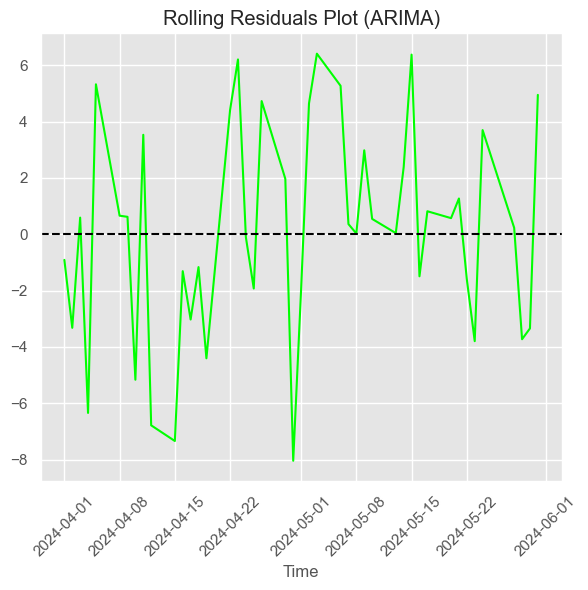

In [628]:
# Residual plot
fig, ax = plt.subplots(figsize = (6, 6))

rolling_residuals = df['actual'] - df['predicted']

plt.plot(rolling_residuals, color = 'lime');
plt.title('Rolling Residuals Plot (ARIMA)')
plt.xticks(rotation = 45);
plt.axhline(0, linestyle='--', color = 'black');
plt.xlabel('Time');

plt.tight_layout()

plt.savefig('arima_residuals.png', dpi = 300)

Again, the residuals are not random, so our model is still failing to capture some pattern in the data.

## Random Walk Model

Random Walk will be our baseline model to compare against. The theory behind random walk is that there is no relationship between the past prices and the future prices of a stock.

So to predict the adjusted close price of a stock, we would follow

$\hat y_{T+h|T} = y_{T}$ where h is the hth day that we are forecasting and T is the last closing price we have in the data

The random walk model's residuals are not random.

## Rolling Prediction for Random Walk

In [629]:
# Rolling forecast origin
rolling_predictions = pd.Series()
for end_date in og_spy_test.index:
    train_data = spy_data[:end_date.to_timestamp()-timedelta(days=1)]
    rolling_predictions.loc[end_date] = train_data.iloc[-1]

In [630]:
# Get results into a dataframe
df_rw = pd.concat([og_spy_test, rolling_predictions], join = 'inner', axis = 1)
df_rw.columns = ['actual', 'predicted']
df_rw.index = df_rw.index.to_timestamp()

#print results RMSE
print(f"RMSE of Random Walk (rolling predictions): {root_mean_squared_error(df_rw['actual'], df_rw['predicted'])}")

RMSE of Random Walk (rolling predictions): 3.776374679072115


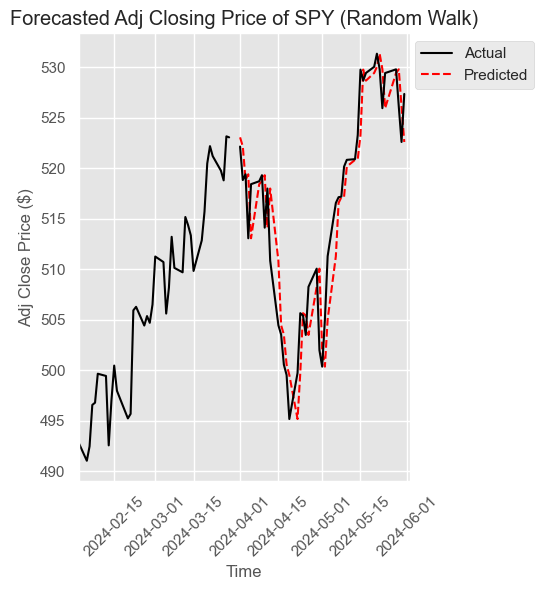

In [631]:
# Visualizing forecast
fig, ax = plt.subplots(figsize = (6, 6))

ax.plot(og_spy_train_timestamp, color = 'black')
plt.xlim(og_spy_train_timestamp.index[0], TEST_END);
ax.plot(df_rw['predicted'], color = 'red', linestyle = '--')
ax.plot(df_rw['actual'], color = 'black')
plt.xticks(rotation = 45);
plt.xlabel('Time');
plt.ylabel('Adj Close Price ($)');
plt.title('Forecasted Adj Closing Price of SPY (Random Walk)');
plt.legend(labels = ['Actual', 'Predicted'], loc = 'upper right', bbox_to_anchor=(1.4, 1));
plt.tight_layout()

plt.savefig('rw_plot.png', dpi = 300)

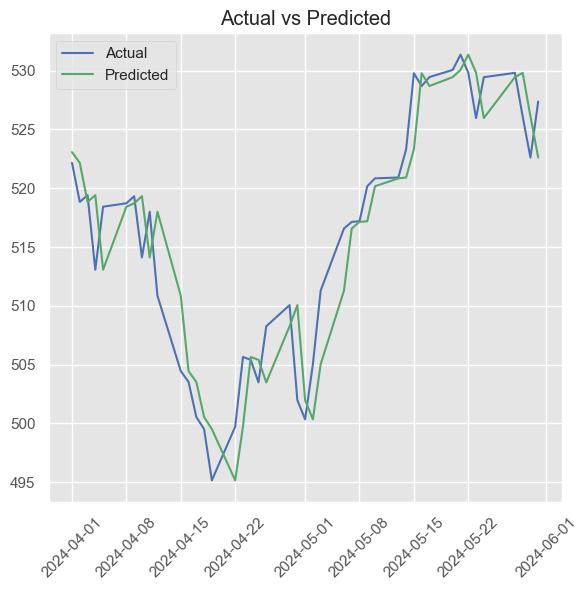

In [632]:
# Actual vs Predicted
fig, ax = plt.subplots(figsize = (6, 6))

plt.plot(df_rw['actual'], color = 'b');
plt.plot(df_rw['predicted'], color = 'g');
plt.xticks(rotation = 45);
plt.title("Actual vs Predicted");
plt.legend(labels = ['Actual', 'Predicted']);
plt.tight_layout()

plt.savefig('rw_actual_predicted.png', dpi = 300)

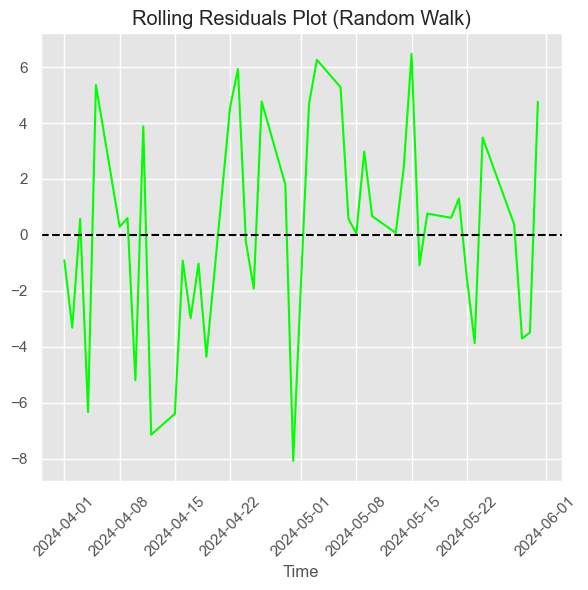

In [633]:
# Residual Plot
fig, ax = plt.subplots(figsize = (6, 6))

residuals = df_rw['actual'] - df_rw['predicted']
plt.plot(residuals, color = 'lime');
plt.xticks(rotation = 45);
plt.title('Rolling Residuals Plot (Random Walk)');
plt.axhline(0, linestyle='--', color = 'black');
plt.xlabel('Time');

plt.tight_layout()

plt.savefig('rw_residuals.png', dpi = 300)